In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import re

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

hp='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/1000_random_hyperparameters.tsv'
nvar='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/NVAR_per_MAF_bin'
r2s='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/mean_r2_pop.txt'

In [2]:
#hp_data = np.genfromtxt(fname=hp, delimiter="\t", skip_header=0, names=True)
hp_data = pd.read_csv(hp,sep="\t")
nvar_data = pd.read_csv(nvar,sep="\t",index_col=False, header=None, names=["FILE","(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"])
#del nvar_data['FILE']
r2s_data = pd.read_csv(r2s,sep="\t",index_col=False, header=None, names=hp_data['#model_id'][0:100])

In [3]:
nvar_data

,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,0.047755
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,0.016495
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,0.016718
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,0.018430
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,0.058140
...,...,...,...,...,...,...,...,...,...,...,...,...
251,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,0.000473
252,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,0.045278
253,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,0.023946
254,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,0.018000


In [4]:
hp_data

,#model_id,l1,l2,beta,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,model_1,1.000000e-07,1.000000e-08,0.00010,0.050,0.0,1,0.00100,leakyrelu,rmsprop,FL,8,0.7,0.5000
1,model_2,0.000000e+00,1.000000e-02,0.00000,0.500,4.0,1,0.01000,leakyrelu,rmsprop,CE,6,0.9,0.2500
2,model_3,1.000000e-01,1.000000e-07,0.10000,0.500,1.0,0,0.10000,tanh,rmsprop,CE,8,1.0,0.2500
3,model_4,1.000000e-05,1.000000e-02,1.00000,0.500,5.0,1,0.00001,leakyrelu,adadelta,CE,8,0.8,0.9500
4,model_5,0.000000e+00,1.000000e-05,0.00000,0.005,0.0,1,0.00010,relu,adam,CE,4,0.5,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,model_996,1.000000e-04,1.000000e-03,0.00001,0.250,3.0,1,0.00100,tanh,adam,CE,4,0.5,0.9900
996,model_997,1.000000e-08,0.000000e+00,10.00000,0.005,0.0,0,0.00001,relu,adadelta,FL,8,0.4,0.5000
997,model_998,0.000000e+00,1.000000e-05,5.00000,0.250,4.0,1,0.00010,tanh,sgd,FL,2,0.2,0.9999
998,model_999,0.000000e+00,0.000000e+00,0.00100,0.005,2.0,0,0.00010,relu,rmsprop,FL,4,1.2,0.7500


In [5]:
r2s_data

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,...,model_91,model_92,model_93,model_94,model_95,model_96,model_97,model_98,model_99,model_100
0,0.117721,0.005714,0.000000,0.014596,0.193800,0.004243,0.026460,0.0,0.049099,0.000000,...,0.004478,0.014229,0.015059,0.003933,0.004864,0.028335,0.030055,0.029014,0.003220,0.002822
1,0.041652,0.008651,0.000168,0.011131,0.103835,0.003975,0.021146,NaN,0.008285,0.001864,...,0.006443,0.004995,0.012028,0.006484,0.008254,0.022467,0.018999,0.021858,0.005890,0.003411
2,0.068386,0.017298,0.000000,0.008022,0.190235,0.004571,0.016748,0.0,0.011665,0.000000,...,0.013031,0.003079,0.008164,0.007710,0.008457,0.016683,0.016356,0.017136,0.010912,0.011544
3,0.065725,0.008365,0.000000,0.008527,0.185116,0.002648,0.016085,0.0,0.027839,0.000000,...,0.002517,0.003865,0.007533,0.002002,0.007424,0.017112,0.016809,0.016250,0.003027,0.003212
4,0.059619,0.018961,0.000000,0.015005,0.108487,0.002948,0.032244,0.0,0.000685,0.005310,...,0.003727,0.004853,0.011699,0.059999,0.002896,0.031725,0.031265,0.039824,0.012052,0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.032882,0.000408,0.000000,0.015742,0.169929,0.063441,0.034945,NaN,0.092633,0.000000,...,0.076118,0.087656,0.015517,0.048025,0.018373,0.037486,0.038516,0.039095,0.068895,0.022444
252,0.058854,0.004899,0.000000,0.008315,0.147670,0.000485,0.017570,0.0,0.034039,0.001342,...,0.002224,0.002708,0.007753,0.002482,0.003078,0.017911,0.018362,0.020507,0.005091,0.003701
253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,0.046217,0.001735,0.000000,0.007211,0.124648,0.005520,0.017676,0.0,0.038830,0.000000,...,0.008281,0.043568,0.007606,0.008628,0.003591,0.018948,0.019406,0.019328,0.007844,0.005773


In [6]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
r2s_data.iloc[:,:] = imputer.fit_transform(r2s_data)

In [7]:
hp_data_repeated = pd.concat([hp_data.iloc[0:100,:]]*256, ignore_index=True).sort_values(by='#model_id').reset_index()
nvar_data_repeated = pd.concat([nvar_data]*100, ignore_index=True)

In [8]:
hp_data_repeated

,index,#model_id,l1,l2,beta,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,0,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
1,11400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
2,18400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
3,5400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
4,3100,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,22798,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25596,13498,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25597,15998,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25598,18998,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75


In [9]:
nvar_data_repeated

,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,0.047755
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,0.016495
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,0.016718
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,0.018430
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,0.058140
...,...,...,...,...,...,...,...,...,...,...,...,...
25595,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,0.000473
25596,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,0.045278
25597,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,0.023946
25598,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,0.018000


In [10]:
nvar_hp = pd.concat([nvar_data_repeated, hp_data_repeated], axis=1)

In [11]:
nvar_hp

,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]",...,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25596,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25597,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25598,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75


In [12]:
nvar_hp_one_hot = pd.get_dummies(nvar_hp, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
del nvar_hp_one_hot['index']
del nvar_hp_one_hot['#model_id']
del nvar_hp_one_hot['FILE']

nvar_hp_one_hot['r2'] = r2s_data.values.flatten('F')

In [13]:
nvar_hp_one_hot.columns.values

array(['(0.0, 0.0001]', '(0.0001, 0.0005]', '(0.0005, 0.001]',
       '(0.001, 0.005]', '(0.005, 0.01]', '(0.01, 0.05]', '(0.05, 0.1]',
       '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', 'l1', 'l2',
       'beta', 'rho', 'gamma', 'disable_alpha', 'learn_rate', 'n_layers',
       'size_ratio', 'decay_rate', 'one_hot_leakyrelu', 'one_hot_relu',
       'one_hot_sigmoid', 'one_hot_tanh', 'one_hot_adadelta',
       'one_hot_adagrad', 'one_hot_adam', 'one_hot_rmsprop',
       'one_hot_sgd', 'one_hot_CE', 'one_hot_FL', 'r2'], dtype=object)

In [14]:
nvar_hp_one_hot

,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]",...,one_hot_sigmoid,one_hot_tanh,one_hot_adadelta,one_hot_adagrad,one_hot_adam,one_hot_rmsprop,one_hot_sgd,one_hot_CE,one_hot_FL,r2
0,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,...,0,0,0,0,0,1,0,0,1,0.117721
1,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,...,0,0,0,0,0,1,0,0,1,0.041652
2,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,...,0,0,0,0,0,1,0,0,1,0.068386
3,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,...,0,0,0,0,0,1,0,0,1,0.065725
4,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,...,0,0,0,0,0,1,0,0,1,0.059619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,...,0,0,1,0,0,0,0,0,1,0.022444
25596,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,...,0,0,1,0,0,0,0,0,1,0.003701
25597,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,...,0,0,1,0,0,0,0,0,1,0.029354
25598,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,...,0,0,1,0,0,0,0,0,1,0.005773


In [15]:
nvar_hp_one_hot_normalized = nvar_hp_one_hot.copy()
# apply normalization techniques 
for column in nvar_hp_one_hot_normalized.columns: 
    nvar_hp_one_hot_normalized[column] = nvar_hp_one_hot[column]  / nvar_hp_one_hot[column].abs().max() 

In [16]:
X = pd.DataFrame(nvar_hp_one_hot.iloc[:,:-1])
y = pd.DataFrame(nvar_hp_one_hot['r2'])

lmodel = LinearRegression()
xmodel = xgb.XGBRegressor(random_state = 123)
rmodel = RandomForestRegressor(n_estimators = 100, random_state = 123)

lscores = []
xscores = []
rscores = []
ly_preds = []
y_trues = []
xy_preds = []
ry_preds = []

#clean column labels, required for xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

kfold = KFold(n_splits = 10, shuffle = True, random_state = 123)

for i, (train, test) in enumerate(kfold.split(X, y)):
    print("Iteration", i)
    lmodel.fit(X.iloc[train,:], y.iloc[train,:])
    xmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    rmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    lscore = lmodel.score(X.iloc[test,:], y.iloc[test,:])
    xscore = xmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    rscore = rmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), lmodel.predict(X.iloc[test,:]).flatten())
    y_trues += list(np.array(y.iloc[test,:]).flatten())
    ly_preds += list(lmodel.predict(X.iloc[test,:]).flatten())
    xy_preds += list(xmodel.predict(X.iloc[test,:]).flatten())
    ry_preds += list(rmodel.predict(X.iloc[test,:]).flatten())

    lscores.append(lscore)
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), xmodel.predict(X.iloc[test,:]).flatten())
    xscores.append(xscore)
    rscores.append(rscore)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


[0.12744896333203581, 0.14456219934616232, 0.16569143279583698, 0.1267254889506757, 0.09306757607381633, 0.12232072574015684, 0.15231203896805667, 0.1280060361661064, 0.11421719670728248, 0.1443072757356071]


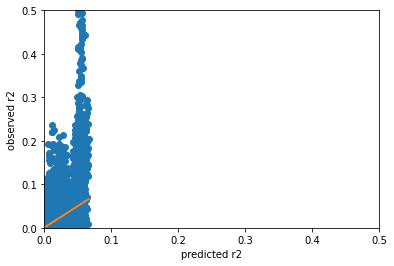

In [20]:
#create basic scatterplot
plt.plot(ly_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(ly_preds, y_trues, 1)
slope = m*np.asarray(ly_preds)+b
#add linear regression line to scatterplot 
plt.plot(ly_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(lscores)

[0.7881893290788683, 0.8108383390649347, 0.7788165113208125, 0.7881114496853107, 0.7588874684362439, 0.7659821092941238, 0.8087863093179541, 0.7573271668015642, 0.7170071925111213, 0.795337267097068]


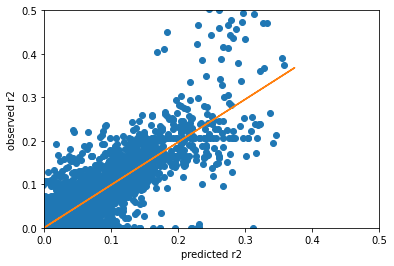

In [21]:
#create basic scatterplot
plt.plot(xy_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(xy_preds, y_trues, 1)
slope = m*np.asarray(xy_preds)+b
#add linear regression line to scatterplot 
plt.plot(xy_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(xscores)

[0.749435378850215, 0.7747397538459193, 0.7415631624573349, 0.7582597600615273, 0.7123520466875436, 0.7210567723359894, 0.7820188500087557, 0.7158570746430138, 0.6652094784313309, 0.7547471906630697]


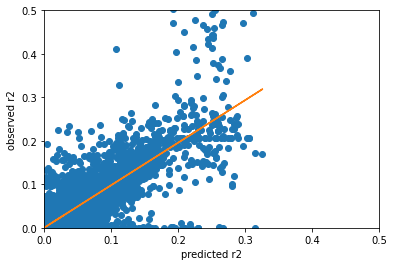

In [22]:
#create basic scatterplot
plt.plot(ry_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(ry_preds, y_trues, 1)
slope = m*np.asarray(ry_preds)+b
#add linear regression line to scatterplot 
plt.plot(ry_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(rscores)

In [23]:
full_hp_data_repeated = pd.concat([hp_data]*256, ignore_index=True).sort_values(by='#model_id').reset_index()
full_nvar_data_repeated = pd.concat([nvar_data]*1000, ignore_index=True)
full_nvar_hp = pd.concat([full_nvar_data_repeated, full_hp_data_repeated], axis=1)

full_nvar_hp_one_hot = pd.get_dummies(full_nvar_hp, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
del full_nvar_hp_one_hot['index']
del full_nvar_hp_one_hot['#model_id']
del full_nvar_hp_one_hot['FILE']

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
full_nvar_hp_one_hot.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in full_nvar_hp_one_hot.columns.values]
full_nvar_hp['r2_pred'] = xmodel.predict(full_nvar_hp_one_hot)

In [24]:
vmvs = []
bests = []
for vmv in full_nvar_hp['FILE'].unique():
    vmv_data = full_nvar_hp.loc[full_nvar_hp['FILE'] == vmv]
    max_r2 = vmv_data['r2_pred'].max()
    best = vmv_data.loc[vmv_data['r2_pred'] == max_r2]
    vmvs.append(vmv)
    bests.append(best)
result = pd.concat(bests)
summary = pd.DataFrame([vmvs, result['#model_id']]).transpose()

In [25]:
summary

,0,1
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,model_806
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,model_647
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,model_806
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,model_806
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,model_864
...,...,...
251,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,model_504
252,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_84
253,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_84
254,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_806


In [26]:
np.unique(result['#model_id'])

array(['model_169', 'model_184', 'model_312', 'model_328', 'model_365',
       'model_46', 'model_479', 'model_504', 'model_533', 'model_545',
       'model_546', 'model_647', 'model_69', 'model_722', 'model_754',
       'model_778', 'model_805', 'model_806', 'model_812', 'model_818',
       'model_84', 'model_864', 'model_873', 'model_876'], dtype=object)

In [27]:
len(np.unique(result['#model_id']))

24

In [28]:
unique, frequency = np.unique(result['#model_id'],  
                              return_counts = True) 

In [29]:
pd.DataFrame([unique,frequency]).transpose()

,0,1
0,model_169,1
1,model_184,7
2,model_312,1
3,model_328,2
4,model_365,7
5,model_46,2
6,model_479,4
7,model_504,22
8,model_533,1
9,model_545,7


In [30]:
feature_names = list(full_nvar_hp_one_hot.columns)

In [31]:
import shap
shap.initjs()
shap_values = shap.TreeExplainer(xmodel).shap_values(full_nvar_hp_one_hot)


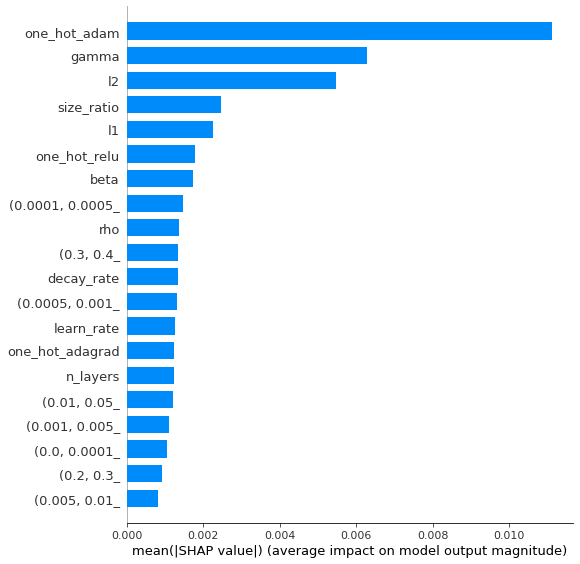

In [32]:
shap.summary_plot(shap_values, full_nvar_hp_one_hot, plot_type="bar")


In [33]:
shap_interaction_values = shap.TreeExplainer(xmodel).shap_interaction_values(full_nvar_hp_one_hot)

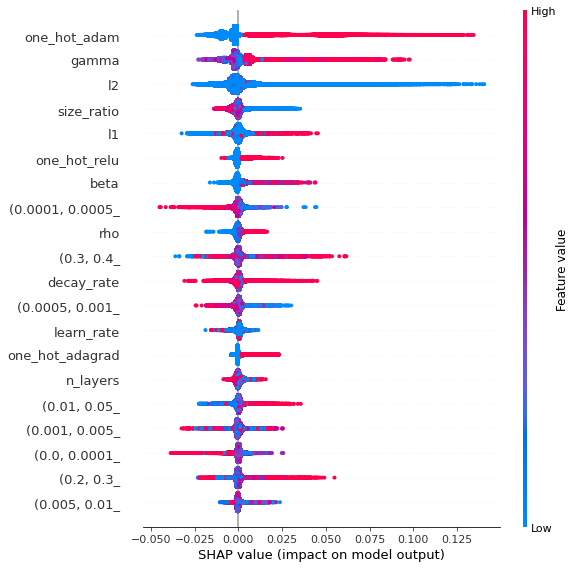

In [34]:
shap.summary_plot(shap_values, full_nvar_hp_one_hot)

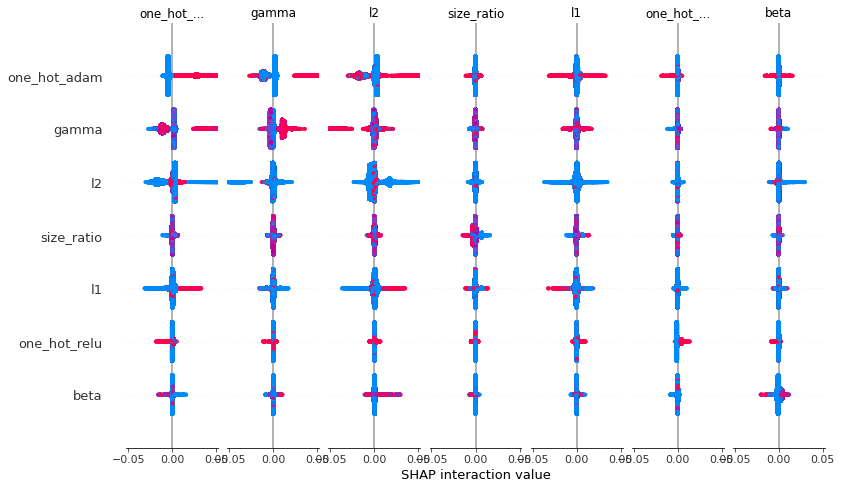

In [35]:
shap.summary_plot(shap_interaction_values, full_nvar_hp_one_hot, plot_type="bar")

In [54]:
explainer = shap.TreeExplainer(xmodel)
expected_value = explainer.expected_value
